In [1]:
davide = "loser"

In [231]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [232]:
import os
import torch
from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import models
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, Subset
import time
import random 

from sklearn.metrics import f1_score

In [233]:
if torch.backends.mps.is_built():
    device = torch.device("mps")
    print("M1 pro GPU is activated")
else:
    device = torch.device("cuda")
    cuda_id = torch.cuda.current_device()
    print(f"ID of current CUDA device:{torch.cuda.current_device()}")
        
    print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

M1 pro GPU is activated


In [234]:
torch.cuda.is_available()

False

We will import the images already resized 250 x 250

In [5]:
x = torch.load("images_data.pt")


In [149]:
valid_data[len(valid_data)-1]

/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


{'image': tensor([[[-1.0390, -1.0219, -0.8678,  ..., -0.7650, -0.6794, -0.6281],
          [-0.7822, -0.8507, -0.8164,  ..., -0.7822, -0.7137, -0.6623],
          [-0.4911, -0.6452, -0.7137,  ..., -0.8335, -0.7822, -0.7822],
          ...,
          [ 0.9132,  0.9132,  0.8789,  ...,  1.0502,  0.8961,  0.6734],
          [ 0.9817,  0.9817,  0.9474,  ...,  0.8789,  0.7591,  0.6049],
          [ 1.0331,  1.0159,  0.9817,  ...,  0.7591,  0.7248,  0.6906]],
 
         [[-0.7927, -0.7402, -0.5651,  ..., -0.4426, -0.3550, -0.3025],
          [-0.5301, -0.5651, -0.5126,  ..., -0.4951, -0.4251, -0.3901],
          [-0.2325, -0.3550, -0.4076,  ..., -0.5651, -0.5126, -0.5126],
          ...,
          [ 0.9230,  0.9230,  0.8880,  ...,  0.7654,  0.6078,  0.3803],
          [ 0.9930,  0.9930,  0.9580,  ...,  0.5903,  0.4678,  0.3102],
          [ 1.0455,  1.0280,  0.9930,  ...,  0.4678,  0.4328,  0.3978]],
 
         [[-1.1247, -1.1073, -1.0027,  ..., -0.6018, -0.5147, -0.4624],
          [-0.8633,

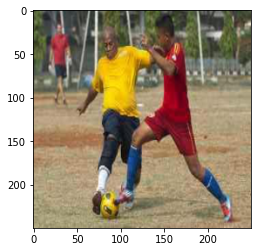

In [150]:
plt.imshow(x[29999].permute(1, 2, 0))
plt.show()

In [39]:
with open('train.csv') as fp:
    # read a list of lines into data
    data = fp.readlines()

data[4790] = data[4790].replace("/", "")
data[14716] = data[14716].replace("/", "")
data[14961] = data[14961].replace("/", "")
data[29895] = data[29895].replace("/", "")

# and write everything back
with open('train.csv', 'w') as file:
    file.writelines(data)

In [40]:
import re
import pandas as pd
from io import StringIO
FILENAME = 'train.csv'
with open(FILENAME) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_train = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

In [41]:
import re
import pandas as pd
from io import StringIO
FILENAME = 'test.csv'
with open(FILENAME) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_test = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

In [42]:
# for i in range(df_train.shape[0]):
#     df_train.Labels[i] = [int(j) for j in df_train.Labels[i].split()]
# max_i = 0
# for i in df_train.Labels:
#     max_i = max(max_i, max(i))
# min_i = 19
# for i in df_train.Labels:
#     min_i = min(min_i, min(i))
# min_i

# for i in range(1, max_i+1):
#     df_train[f'{i}'] = 0
# for i in range(df_train.shape[0]):
#     for j in df_train.Labels[i]:
#         df_train[f"{j}"][i] = 1
# df_train.to_csv("df_train.csv", index=False)

In [43]:
df_train.head()

,ImageID,Labels,Caption
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.
1,1.jpg,1 19,A couple of men riding horses on top of a gree...
2,2.jpg,1,They are brave for riding in the jungle on tho...
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.


In [44]:
for i in range(df_train.shape[0]):
    if f"{i}.jpg" != df_train.loc[i,'ImageID']:
        print(i)

In [45]:
df_train = pd.read_csv("df_train.csv")

In [46]:
df_train.head()

,ImageID,Labels,Caption,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,0.jpg,[1],Woman in swim suit holding parasol on sunny day.,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.jpg,"[1, 19]",A couple of men riding horses on top of a gree...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2.jpg,[1],They are brave for riding in the jungle on tho...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.jpg,"[8, 3, 13]",a black and silver clock tower at an intersect...,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,4.jpg,"[8, 3, 7]",A train coming to a stop on the tracks out side.,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [47]:
df_train = df_train.drop(['12'], axis=1)
df_train.head()

,ImageID,Labels,Caption,1,2,3,4,5,6,7,...,9,10,11,13,14,15,16,17,18,19
0,0.jpg,[1],Woman in swim suit holding parasol on sunny day.,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.jpg,"[1, 19]",A couple of men riding horses on top of a gree...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2.jpg,[1],They are brave for riding in the jungle on tho...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.jpg,"[8, 3, 13]",a black and silver clock tower at an intersect...,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,4.jpg,"[8, 3, 7]",A train coming to a stop on the tracks out side.,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [48]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

nltk.download('punkt')
nltk.download('stopwords')

def preprocess_string(input_string):
    # Tokenize the input string using NLTK's word_tokenize function
    tokens = nltk.word_tokenize(input_string)
    
    # Convert all tokens to lowercase
    tokens = [token.lower() for token in tokens]

    # Remove punctuation
    tokens = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens]
    
    # Remove stop words (common words that don't add much meaning)
    stop_words = set(stopwords.words('english'))
    #tokens = [token for token in tokens if not token in stop_words]
    tokens = [token for token in tokens if token and not token in stop_words]
    
    # Stem the tokens (reduce each token to its root form)
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    
    return tokens

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yaraslauivashynka/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yaraslauivashynka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
# tkn = preprocess_string("Yari, the man, was once seen sitting on the couch and sipping too few boba teas")
# tkn

In [50]:
embedding_size = 20
vob_size = 63

def word_embedding(input_seq, vob_size, dtype=torch.float):
    word_embed = nn.Embedding(vob_size, embedding_size)
    embeddings = word_embed(input_seq.long())
    return embeddings

In [141]:
from torch.utils.data import Dataset

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

class TrainDataset(Dataset):
    def __init__(self, images, csv, train = True, test = False,full=False):
        self.csv = csv # df_train
        self.train = train # boolean
        self.full = full
        self.test = test # boolean
        self.images = images

        self.all_image_names = self.csv[:]['ImageID']
        self.captions = self.csv[:]['Caption']

        #self.all_labels = np.array(self.csv.drop(['ImageID', 'Labels', 'Caption'], axis=1))

        self.train_ratio = int(0.85 * len(self.csv))
        self.valid_ratio = len(self.csv) - self.train_ratio

        # set the training data images and labels
        if self.full == True:
            self.all_labels = np.array(self.csv.drop(['ImageID', 'Labels', 'Caption'], axis=1))
            
            self.image_names = list(self.all_image_names)
            self.labels = list(self.all_labels)
            print(f"Number of training images: {self.all_labels.shape[0]}")
            # define the training transforms
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=45),
                # transforms.ColorJitter(),
                transforms.Normalize(mean, std)

            ])
        elif self.train == True:
            self.all_labels = np.array(self.csv.drop(['ImageID', 'Labels', 'Caption'], axis=1))
            print(f"Number of training images: {self.train_ratio}")
            self.image_names = list(self.all_image_names[:self.train_ratio])
            self.images = self.images[:self.train_ratio]
            self.labels = list(self.all_labels[:self.train_ratio])
            self.captions = list(self.captions[:self.train_ratio])
            # define the training transforms
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=45),
                # transforms.ColorJitter(),
                transforms.Normalize(mean, std)
            ])
        # set the validation data images and labels
        elif self.train == False and self.test == True:
            self.all_labels = np.array(self.csv.drop(['ImageID', 'Labels','Caption'], axis=1))
            print(f"Number of validation images: {self.valid_ratio}")
            self.images = self.images[-self.valid_ratio:]
            self.image_names = list(self.all_image_names[-self.valid_ratio:])
            self.labels = list(self.all_labels[-self.valid_ratio:])
            self.captions = list(self.captions[-self.valid_ratio:])
            # define the validation transforms
            self.transform = transforms.Compose([
                transforms.Normalize(mean, std)
            ])
            
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        
        image = self.images[index]
        image = self.transform(image)
        caption = self.captions[index]
        if self.train == True:   #training
            targets = self.labels[index]
            return {
            'image': torch.tensor(image, dtype=torch.float32),
            'label': torch.tensor(targets, dtype=torch.float32),
            'name' : self.image_names[index],
            'caption' : caption,
        }
        elif self.train == False and self.test == True:  #validation
             targets = self.labels[index]
             return {
            'image': torch.tensor(image, dtype=torch.float32),
            'label': torch.tensor(targets, dtype=torch.float32),
            'caption' : caption,
            'name' : self.image_names[index],
        }
        elif self.test == True and self.train == False:   #testing
            return {
            'image': torch.tensor(image, dtype=torch.float32),
            'name' : self.all_image_names[index],
            'caption' : caption,
        }
       
        
        

In [142]:
class TestDataset(Dataset):
    def __init__(self, images, csv):
        self.csv = csv
        self.images = images

        self.all_image_names = self.csv[:]['ImageID']
        self.captions = self.csv[:]['Caption']
        print(f"Number of test images: {len(self.csv)}")
        self.transform = transforms.Compose([
            transforms.Normalize(mean, std)
        ])
            
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self, index):
        image = self.images[index]
        image = self.transform(image)
        caption = self.captions[index]
        return {
        'image': torch.tensor(image, dtype=torch.float32),
        'name' : self.all_image_names[index],
        'caption' : caption,
        }
       

In [151]:
batch_size = 32
train_data = TrainDataset(
    x[:30000], df_train, train=True, test=False
)
# validation dataset
valid_data = TrainDataset(
    x[:30000], df_train, train=False, test=True
)

full_data = TrainDataset(
    x[:30000],csv = df_train, full=True
)

test_data = TestDataset(
    x[-10000:],csv = df_test
)

train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)
# validation data loader
valid_loader = DataLoader(
    valid_data, 
    batch_size=batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False
)

full_loader = DataLoader(
    full_data,
    batch_size=batch_size,
    shuffle=True
)

Number of training images: 25500
Number of validation images: 4500
Number of training images: 30000
Number of test images: 10000


In [144]:
len(valid_data), valid_data[0]['name'], valid_data[len(valid_data)-1]['name'], train_data[0]['name'], train_data[len(train_data)-1]['name'], len(train_data)

/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


(4500, '25500.jpg', '29999.jpg', '0.jpg', '25499.jpg', 25500)

In [136]:
valid_data[0]['caption']

/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3309657396.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


'Woman in swim suit holding parasol on sunny day.'

In [121]:
plt.imshow(valid_data[len(valid_data) - 1]['image'].permute(1, 2, 0))
plt.show()

AttributeError: 'TrainDataset' object has no attribute 'image_names'

In [23]:
valid_data[len(valid_data) - 1]['caption']

/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21147/375505942.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


'There are a coupe of dozen vases left out.'

# Distribution of Labels

In [24]:
# label_df = df_train.explode("Labels")
# label_counts = label_df['Labels'].value_counts()
# sorted_label_counts = label_counts.sort_index()
# #sorted_label_counts.plot.bar()
# plt.bar(sorted_label_counts.index, sorted_label_counts.values)
# plt.xlabel('Label')
# plt.ylabel('Count')
# plt.title("Label Distribution")
# plt.yticks(np.arange(0, 24000, step=1000))
# plt.xticks(sorted_label_counts.index, sorted_label_counts.index)
# plt.grid()
# plt.show()


In [25]:
# sorted_label_counts

# Networks


In [ ]:
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

Using cache found in /Users/yaraslauivashynka/.cache/torch/hub/pytorch_vision_v0.6.0
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [198]:
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        alexnet = AlexNet_model.to(device)
        alexnet.classifier[4] = nn.Linear(4096,1024)
        alexnet.classifier[6] = nn.Linear(1024,num_classes)
        self.base_model = alexnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

    def calculate_f1_score_and_loss(self, loader, criterion, device=None):
        self.eval()
        val_loss = torch.zeros(len(loader))
        with torch.no_grad():
            y_pred = []
            y_true = []
            for i, data in enumerate(loader):
                images = data['image'].to(device)
                target = data['label'].to(device)
                outputs = self(images).to(device)
                loss = criterion(outputs, target)
                val_loss[i] = loss.item()
                outputs = outputs.cpu().numpy()
                argmax_indices = np.argmax(outputs, axis=1)
                outputs[np.arange(outputs.shape[0]), argmax_indices] = 1
                predicted = np.round(outputs)
                y_pred.extend(predicted)
                y_true.extend(target.cpu().numpy())
            y_pred = np.array(y_pred)
            y_true = np.array(y_true)
            res = f1_score(y_true=y_true, y_pred=y_pred, average='samples')
        return {'f1_score' : res, 'loss' : val_loss.mean()}

Using cache found in /Users/yaraslauivashynka/.cache/torch/hub/pytorch_vision_v0.6.0
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [217]:

#Use the torchvision's implementation of ResNeXt, but add FC layer for a different number of classes (27) and a Sigmoid instead of a default Softmax.
class Resnext50(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        resnet = models.resnext50_32x4d(pretrained=True).to(device=device)
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=resnet.fc.in_features, out_features=num_classes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

    def calculate_f1_score_and_loss(self, loader, criterion, device=None):
        self.eval()
        val_loss = torch.zeros(len(loader))
        with torch.no_grad():
            y_pred = []
            y_true = []
            for i, data in enumerate(loader):
                images = data['image'].to(device)
                target = data['label'].to(device)
                outputs = self(images).to(device)
                loss = criterion(outputs, target)
                val_loss[i] = loss.item()
                outputs = outputs.cpu().numpy()
                argmax_indices = np.argmax(outputs, axis=1)
                outputs[np.arange(outputs.shape[0]), argmax_indices] = 1
                predicted = np.round(outputs)
                y_pred.extend(predicted)
                y_true.extend(target.cpu().numpy())
            y_pred = np.array(y_pred)
            y_true = np.array(y_true)
            res = f1_score(y_true=y_true, y_pred=y_pred, average='samples')
        return {'f1_score' : res, 'loss' : val_loss.mean()}

In [218]:
best_cv_model = AlexNet(num_classes=18)
best_cv_model = best_cv_model.to(device)
best_cv_model.train()

AlexNet(
  (base_model): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
    

In [219]:
save_freq = 3
lr = 1e-4
weight_decay = 0 
num_epochs = 20
optimizer = torch.optim.Adam(best_cv_model.parameters(),weight_decay=weight_decay, lr=lr)
criterion = nn.BCELoss()

In [220]:
name_of_model = f'AlexNet_lr={lr}_weight_decay={weight_decay}_dropout=0.5'
os.mkdir(name_of_model)
train_losses = np.zeros(num_epochs)
valid_losses = np.zeros(num_epochs)
f1_scores = np.zeros(num_epochs)
for it in range(num_epochs):
    train_loss = 0
    for i, data in enumerate(train_loader):
        images = data['image'].to(device)
        target = data['label'].to(device)
        optimizer.zero_grad()
        outputs = best_cv_model(images)
        loss = criterion(outputs, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    print(it)
    if ((it % save_freq == 0) or (it == num_epochs - 1)) and it > 0:
        checkpoint_path = f'{name_of_model}/{name_of_model}{it}.pth'
        checkpoint = {'model': best_cv_model.state_dict(),
                  'optimizer': optimizer.state_dict(),
                  'epoch': num_epochs}
        torch.save(checkpoint, checkpoint_path)
    train_losses[it] = train_loss/len(train_loader)
    result = best_cv_model.calculate_f1_score_and_loss(valid_loader, criterion=criterion, device=device)
    valid_losses[it] = result['loss']
    f1_scores[it] = result['f1_score']
    

/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


0


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


1


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


2


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


3


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


4


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


5


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


6


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


7


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


8


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


9


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


10


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


11


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


12


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


13


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


14


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


15


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


16


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


17


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


18


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


19


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


In [205]:
train_losses, valid_losses, f1_scores

(array([0.000864  , 0.00086402, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 array([0.68864805, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 array([0.08370356, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]))

In [ ]:
# checkpoint_path = 'ResNet7.pth'
# checkpoint = {'model': best_cv_model.state_dict(),
#               'optimizer': optimizer.state_dict(),
#               'epoch': num_epochs}
# torch.save(checkpoint, checkpoint_path)

In [230]:
submission = predict_test_data_vision(best_cv_model, test_loader=test_loader, device=device, batch_size = batch_size)
submission

/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/1349538465.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


NotImplementedError: The operator 'aten::_index_put_impl_' is not current implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [ ]:
submission.to_csv('predictions.csv',index=False)

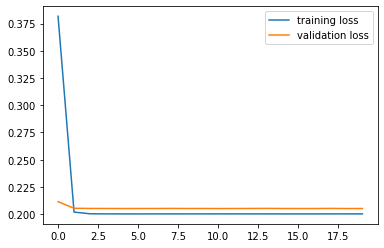

In [223]:
plt.plot(np.arange(num_epochs),train_losses, label = "training loss")
plt.plot(np.arange(num_epochs),valid_losses,label = "validation loss")
plt.legend()
plt.show()

In [226]:
train_losses

array([0.38166307, 0.20189641, 0.20034434, 0.20026146, 0.20024314,
       0.20023084, 0.20024587, 0.20023862, 0.20024488, 0.20024909,
       0.20025804, 0.20025977, 0.20024794, 0.2002399 , 0.20023679,
       0.20024521, 0.20024102, 0.20025424, 0.20026087, 0.20024294])

In [225]:
valid_losses

array([0.21149832, 0.20538977, 0.20523812, 0.20521383, 0.20516698,
       0.20519844, 0.20519938, 0.20526612, 0.20519568, 0.2052238 ,
       0.20514612, 0.20519555, 0.2052258 , 0.20529369, 0.20519924,
       0.20516862, 0.20517281, 0.20528604, 0.20516007, 0.2051851 ])

In [222]:
f1_scores

array([0.63144286, 0.63144286, 0.63144286, 0.63144286, 0.63144286,
       0.63144286, 0.63144286, 0.63144286, 0.63144286, 0.63144286,
       0.63144286, 0.63144286, 0.63144286, 0.63144286, 0.63144286,
       0.63144286, 0.63144286, 0.63144286, 0.63144286, 0.63144286])

In [228]:
def predict_test_data_vision(model, test_loader, device, batch_size):
    model.eval()
    model = model.to(device)
    df_pred = pd.DataFrame()
    df_pred['ImageID'] = ["" for i in range(len(test_data))]
    df_pred['Labels'] = ["" for i in range(len(test_data))]
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            #images
            images = data['image'].to(device)
            pred = model(images)
            _, argmax_indices = torch.max(pred, dim=1)
            pred[torch.arange(pred.size(0)), argmax_indices] = 1
            pred = (pred >= 0.5).type(torch.uint8)
            start = i*batch_size
            end = min((i+1)*batch_size, len(test_data))
            indices = pred.nonzero()
            indices[indices[:, 1] > 10, 1] += 1
            # print(indices)
            indices_by_row = torch.split(indices[:, 1], indices[:, 0].unique(return_counts=True)[1].tolist())
            # print(indices_by_row)
            results = [" ".join([str(idx.item()+1) for idx in row]) for row in indices_by_row]
            df_pred["ImageID"][start:end] = data['name']
            df_pred["Labels"][start:end] = results

    return df_pred

# our nlp

In [ ]:
df_train = df_train.drop(columns = 'Caption').join(df_train['Caption'].str.replace('\"', ''))
df_test = df_test.drop(columns = 'Caption').join(df_test['Caption'].str.replace('\"', ''))
whole_sentences = pd.concat([df_train['Caption'], df_test['Caption']], axis=0, ignore_index=True)
whole_sentences

0         Woman in swim suit holding parasol on sunny day.
1        A couple of men riding horses on top of a gree...
2        They are brave for riding in the jungle on tho...
3        a black and silver clock tower at an intersect...
4         A train coming to a stop on the tracks out side.
                               ...                        
39995    A group of men riding surfboards riding a mass...
39996    A motorcycle parked next to a car in a parking...
39997              a little boy that is playing with a wii
39998    group of kids play Frisbee golf in the middle ...
39999     A man in a gray jacket standing next to a woman.
Name: Caption, Length: 40000, dtype: object

In [ ]:
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
from nltk.corpus import stopwords as sw
# stop_words = sw.words()
STOPWORDS = set(sw.words('english'))

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def sent_split(input_string): # string to pure word
    splits = []
    for sent in input_string:
        # print(text)
        sent = sent.lower() # lowercase
        sent = re.sub(r'[^A-Za-z]+', ' ', sent) # remove symbols / digits
        # text = re.sub(r'[0-9]','',text)
        orig_sent = []
        for item in sent.split():
            if item not in STOPWORDS: # remove stopword
                orig_sent.append(item)

        lem = [lemmatizer.lemmatize(sent) for sent in orig_sent] # lammatisation

        # token = [word_tokenize(word) for word in text_le]
        splits.append(lem)
    return splits

In [ ]:
max_seq_len = max(len(s) for s in sent_split(whole_sentences))
max_seq_len

28

In [ ]:
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))
word_embedding_model = gensim.downloader.load('word2vec-google-news-300')

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
splitted_sentences = sent_split(whole_sentences)
word_list = []
for sent in splitted_sentences:
    for word in sent:
        word_list.append(word)
len(word_list)

233353

In [ ]:
vocab_list = []
for sent in splitted_sentences:
    for word in sent:
        vocab_list.append(word)

In [ ]:
# Create the Embedding lookup table
import numpy as np
emb_dim = word_embedding_model.vector_size
word_set = set()
min_freq = 5
from collections import Counter
c = Counter(vocab_list)
for i in c:
    if c[i] >= min_freq:
        word_set.add(i)
word_set.add('[PAD]')
word_set.add('[UNKOWN]')
word_list=list(word_set)
word_list.sort()
emb_table = []
word_index = {}
emb_table = []
for i, word in enumerate(word_list):
    word_index[word] = i
    if word in word_embedding_model:
        emb_table.append(word_embedding_model[word])
    else:
        emb_table.append([0]*emb_dim)
emb_table = np.array(emb_table)
    
print(emb_table)
emb_table.shape

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.17480469  0.17871094  0.09082031 ...  0.07568359 -0.11181641
  -0.0625    ]
 ...
 [-0.08544922 -0.10253906 -0.48632812 ...  0.02075195  0.08496094
   0.00061035]
 [-0.07421875 -0.10205078  0.20117188 ... -0.25390625  0.06054688
  -0.21289062]
 [-0.04248047  0.16015625 -0.2265625  ...  0.18945312 -0.00692749
   0.1328125 ]]


(2218, 300)

In [ ]:
class Tokenizer:
    def __init__(self):
        pass
    def tokenize(self, sentences, seq_len, word_index):
        sentences = sent_split(sentences)
        sent_encoded = []
        for sent in sentences:
            temp_encoded = [word_index[word] if word in word_index else word_index['[UNKOWN]'] for word in sent]
            if len(temp_encoded) < seq_len:
                temp_encoded += [word_index['[PAD]']] * (seq_len - len(temp_encoded))
            else:
                temp_encoded = temp_encoded[:seq_len]
            sent_encoded.append(temp_encoded)
        return sent_encoded

In [ ]:
vocab_size = emb_table.shape[0]
emb_dim = emb_table.shape[1]
vocab_size, emb_dim

(2218, 300)

# BiLSTM

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

n_hidden = 300

lr = 1e-4

seq_len = max_seq_len

class Bi_LSTM_Emb(nn.Module):
    def __init__(self,n_classes):
        super(Bi_LSTM_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        # Initialize the Embedding layer with the lookup table we created 
        self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        # Optional: set requires_grad = False to make this lookup table untrainable
        self.emb.weight.requires_grad = False

        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_classes)
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        # Get the embeded tensor
        x = self.emb(x)        
        # we will use the returned h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.
        # details of the outputs from nn.LSTM can be found from: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        lstm_out, (h_n,c_n) = self.lstm(x)
        # concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        return self.sigm(z)

    def calculate_f1_score_and_loss(self, loader, criterion, device):
            self.eval()
            val_loss = 0
            with torch.no_grad():
                y_pred = []
                y_true = []
                for data in loader:
                    captions = tokenizer.tokenize(data['caption'], seq_len, word_index)
                    captions = torch.from_numpy(np.array(captions)).to(device)
                    target = data['label'].to(device)
                    outputs = self(captions)
                    loss = criterion(outputs, target)
                    val_loss += loss.item()
                    outputs = outputs.cpu().numpy()
                    argmax_indices = np.argmax(outputs, axis=1)
                    outputs[np.arange(outputs.shape[0]), argmax_indices] = 1
                    predicted = np.round(outputs)
                    y_pred.extend(predicted)
                    y_true.extend(target.cpu().numpy())
                y_pred = np.array(y_pred)
                y_true = np.array(y_true)
                res = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
            return {'f1_score' : res, 'loss' : val_loss/len(loader)}

In [ ]:
best_nlp_model = Bi_LSTM_Emb(18)
best_nlp_model = best_nlp_model.to(device)
best_nlp_model.train()

Bi_LSTM_Emb(
  (emb): Embedding(2218, 300)
  (lstm): LSTM(300, 300, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=600, out_features=18, bias=True)
  (sigm): Sigmoid()
)

In [ ]:
tokenizer = Tokenizer()
optimizer = torch.optim.Adam(best_nlp_model.parameters(), lr=lr, weight_decay=1e-5)
criterion = nn.BCELoss()

In [ ]:
num_epochs = 20
train_losses = torch.zeros(num_epochs)
val_losses = torch.zeros(num_epochs)
f1_scores = torch.zeros(num_epochs)
for it in range(num_epochs):
    train_loss = 0
    for i, data in enumerate(train_loader):
        best_nlp_model.train()
        captions = tokenizer.tokenize(data['caption'], seq_len, word_index)
        captions = torch.from_numpy(np.array(captions)).to(device)
        target = data['label'].to(device)
        optimizer.zero_grad()
        outputs = best_nlp_model(captions)
        loss = criterion(outputs, target)
        train_loss+=loss.item()
        if i % 100 == 0:
            print(loss.item())
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()
        # print(i)
        # if i % 100 == 0:
        #     print(best_nlp_model.calculate_f1_score_and_loss(valid_loader, criterion,device))
            
    print(it)
    train_losses[it] = train_loss/len(train_loader)
    result = best_nlp_model.calculate_f1_score_and_loss(valid_loader, criterion=criterion, device=device)
    val_losses[it] = result['loss']
    f1_scores[it] = result['f1_score']
    

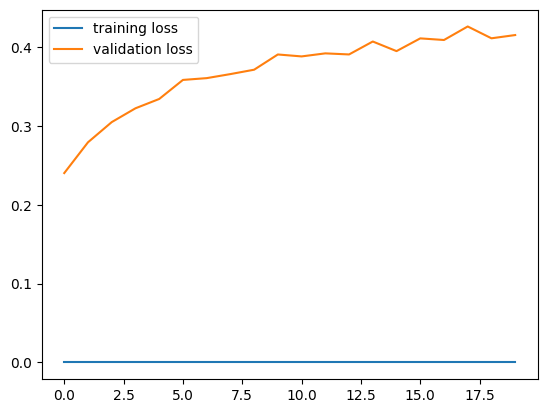

In [ ]:
plt.plot(np.arange(num_epochs),train_losses, label = "training loss")
plt.plot(np.arange(num_epochs),val_losses,label = "validation loss")
plt.legend()
plt.show()

In [ ]:
checkpoint_path = 'BiLSTM3.pth'
checkpoint = {'model': best_nlp_model.state_dict(),
              'optimizer': optimizer.state_dict(),
              'epoch': num_epochs}
torch.save(checkpoint, checkpoint_path)

In [ ]:
best_nlp_model = Bi_LSTM_Emb(19)
checkpoint = torch.load("BiLSTM2.pth")
# Load the model state dictionary from the checkpoint
best_nlp_model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [ ]:
def predict_test_data_caption(model, test_loader, device, batch_size):
    model.eval()
    model = model.to(device)
    y_pred = torch.zeros(len(test_data), 18)
    df_pred = pd.DataFrame()
    df_pred['ImageID'] = ["" for i in range(len(test_data))]
    df_pred['Labels'] = ["" for i in range(len(test_data))]
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            captions = tokenizer.tokenize(data['caption'], seq_len, word_index)
            captions = torch.from_numpy(np.array(captions)).to(device)
            pred = model(captions).to(device)
            _, argmax_indices = torch.max(pred, dim=1)
            pred[torch.arange(pred.size(0)), argmax_indices] = 1
            pred = (pred >= 0.5).type(torch.uint8)
            start = i*batch_size
            end = min((i+1)*batch_size, len(test_data))
            indices = pred.nonzero()
            # indices[indices[:, 1] > 10, 1] += 1
            # print(indices)
            indices_by_row = torch.split(indices[:, 1], indices[:, 0].unique(return_counts=True)[1].tolist())
            # print(indices_by_row)
            results = [" ".join([str(idx.item()+1) for idx in row]) for row in indices_by_row]
            df_pred["ImageID"][start:end] = data['name']
            df_pred["Labels"][start:end] = results

    return df_pred

In [ ]:
submission = predict_test_data_caption(best_nlp_model, test_loader, device, batch_size)
print(submission.head())
submission.to_csv('predictions.csv', index = False)

C:\Users\david\AppData\Local\Temp\ipykernel_26984\782737087.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_26984\782737087.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_26984\782737087.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_26984\78

     ImageID Labels
0  30000.jpg      1
1  30001.jpg      1
2  30002.jpg      1
3  30003.jpg      1
4  30004.jpg      1


# AlexNet

In [32]:
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

Using cache found in /Users/yaraslauivashynka/.cache/torch/hub/pytorch_vision_v0.6.0
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:

#Use the torchvision's implementation of ResNeXt, but add FC layer for a different number of classes (27) and a Sigmoid instead of a default Softmax.
class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        alexnet = AlexNet_model.to(device)
        alexnet.classifier[6] = nn.Linear(4096, num_classes)
        self.base_model = alexnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

    def calculate_f1_score_and_loss(self, loader, criterion, device=None):
        self.eval()
        val_loss = torch.zeros(len(loader))
        with torch.no_grad():
            y_pred = []
            y_true = []
            for i, data in enumerate(loader):
                images = data['image'].to(device)
                target = data['label'].to(device)
                outputs = self(images).to(device)
                loss = criterion(outputs, target)
                val_loss[i] = loss.item()
                outputs = outputs.cpu().numpy()
                argmax_indices = np.argmax(outputs, axis=1)
                outputs[np.arange(outputs.shape[0]), argmax_indices] = 1
                predicted = np.round(outputs)
                y_pred.extend(predicted)
                y_true.extend(target.cpu().numpy())
            y_pred = np.array(y_pred)
            y_true = np.array(y_true)
            res = f1_score(y_true=y_true, y_pred=y_pred, average='samples')
        return {'f1_score' : res, 'loss' : val_loss.mean()}

In [36]:
best_cv_model = AlexNet(num_classes=18)
best_cv_model = best_cv_model.to(device)
best_cv_model.train()


: 

: 

In [ ]:
optimizer = torch.optim.Adam(best_cv_model.parameters(), lr=lr)
criterion = nn.BCELoss()

In [ ]:
train_losses = torch.zeros(num_epochs)
val_losses = torch.zeros(num_epochs)
f1_scores = torch.zeros(num_epochs)
for it in range(num_epochs):
    train_loss = 0
    for i, data in enumerate(train_loader):
        images = data['image'].to(device)
        target = data['label'].to(device)
        optimizer.zero_grad()
        outputs = best_cv_model(images)
        loss = criterion(outputs, target)
        train_loss += loss.item()
        # print(loss.item())
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()
        if i % 5 == 0:
            print(best_cv_model.calculate_f1_score_and_loss(valid_loader, device))
    print(it)
    train_losses[it] = train_loss/len(full_loader)
    result = best_cv_model.calculate_f1_score_and_loss(valid_loader, criterion=criterion, device=device)
    val_losses[it] = result['loss']
    f1_scores[it] = result['f1_score']
    

/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_19125/375505942.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_19125/375505942.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


RuntimeError: Mismatched Tensor types in NNPack convolutionOutput

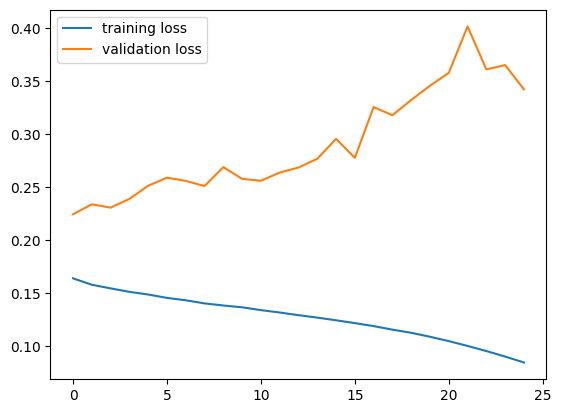

In [ ]:
plt.plot(np.arange(num_epochs),train_losses, label = "training loss")
plt.plot(np.arange(num_epochs),val_losses,label = "validation loss")
plt.legend()
plt.show()

In [ ]:
f1_scores

tensor([0.6314, 0.6314, 0.6314, 0.6314, 0.6314, 0.5497, 0.6223, 0.6296, 0.6309,
        0.6300, 0.6190, 0.5787, 0.5570, 0.5499, 0.4834, 0.5925, 0.3052, 0.3766,
        0.2249, 0.3482, 0.4587, 0.3610, 0.3386, 0.4677, 0.4971])

In [ ]:
checkpoint_path = 'AlexNet2.pth'
checkpoint = {'model': best_cv_model.state_dict(),
              'optimizer': optimizer.state_dict(),
              'epoch': num_epochs}
torch.save(checkpoint, checkpoint_path)

In [ ]:
def calculate_metrics_caption(pred, target, threshold=0.5):
    pred = np.array(pred > threshold, dtype=float)
    return  {
            'f1_score': f1_score(y_true=target, y_pred=pred, average='samples'),
            }

In [ ]:
outputs = model(captions) #could be different from 64 because we are considering only the last trimmed batch
print(len(outputs))
with torch.no_grad():
    result = calculate_metrics_caption(outputs.cpu().numpy(), target.cpu().numpy())
result

32


{'f1_score': 0.40520833333333334}

In [ ]:
x = torch.rand((5,7))
x

tensor([[0.7171, 0.0480, 0.7251, 0.0943, 0.1608, 0.2358, 0.3761],
        [0.5684, 0.0985, 0.9322, 0.4282, 0.5315, 0.9597, 0.0348],
        [0.0113, 0.8012, 0.6290, 0.7249, 0.6215, 0.4123, 0.3687],
        [0.6897, 0.7525, 0.9105, 0.7414, 0.9835, 0.1199, 0.6089],
        [0.5733, 0.3000, 0.3894, 0.5634, 0.3597, 0.9796, 0.1053]])

In [ ]:
_, argmax_indices = torch.max(x, dim=1)
x[torch.arange(x.size(0)), argmax_indices] = 1
x

tensor([[0.7171, 0.0480, 1.0000, 0.0943, 0.1608, 0.2358, 0.3761],
        [0.5684, 0.0985, 0.9322, 0.4282, 0.5315, 1.0000, 0.0348],
        [0.0113, 1.0000, 0.6290, 0.7249, 0.6215, 0.4123, 0.3687],
        [0.6897, 0.7525, 0.9105, 0.7414, 1.0000, 0.1199, 0.6089],
        [0.5733, 0.3000, 0.3894, 0.5634, 0.3597, 1.0000, 0.1053]])

In [ ]:
def predict_test_data_caption(model, test_loader, device, batch_size):
    model.eval()
    y_pred = torch.zeros(len(test_data), 18)
    df_pred = pd.DataFrame()
    df_pred['ImageID'] = ["" for i in range(len(test_data))]
    df_pred['Labels'] = ["" for i in range(len(test_data))]
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            captions = tokenizer.tokenize(data['caption'], seq_len, word_index)
            
            captions = torch.from_numpy(np.array(captions)).to(device)
            #captions = data['Caption'].to(device)
            pred = model(captions)
            _, argmax_indices = torch.max(pred, dim=1)
            pred[torch.arange(pred.size(0)), argmax_indices] = 1
            pred = (pred >= 0.5).type(torch.uint8)
            start = i*batch_size
            end = min((i+1)*batch_size, len(test_data))
            indices = pred.nonzero()
            indices[indices[:, 1] > 10, 1] += 1 ### incrementing labels that are bigger than 10, since we eliminated the 12 label
            indices_by_row = torch.split(indices[:, 1], indices[:, 0].unique(return_counts=True)[1].tolist())
            print(indices_by_row)
            break
            # print(indices_by_row)
            results = [" ".join([str(idx.item()+1) for idx in row]) for row in indices_by_row]
            df_pred["ImageID"][start:end] = data['name']
            df_pred["Labels"][start:end] = results


    return df_pred

In [ ]:
my_indices = torch.tensor([[0,0],[1,14]])
my_indices[:, 1] > 10
my_indices[my_indices[:, 1] > 10, 1] += 1
my_indices

tensor([[ 0,  0],
        [ 1, 15]])

In [ ]:
pred = predict_test_data_caption(best_nlp_model, test_loader, device,batch_size=batch_size)

(tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'))


C:\Users\david\AppData\Local\Temp\ipykernel_2972\1553103947.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


In [ ]:
pred.head(15)

,ImageID,Labels
0,,
1,,
2,,
3,,
4,,
5,,
6,,
7,,
8,,
9,,


In [ ]:
pred.to_csv('predictions.csv',index=False)

# Define a LSTM Model

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

n_hidden = 300

lr = 1e-4

seq_len = max_seq_len

class LSTM(nn.Module):
  def __init__(self, n_class):
    super(LSTM, self).__init__()
    self.emb = nn.Embedding(vocab_size, emb_dim)
    self.emb.weight.data.copy_(torch.from_numpy(emb_table))
    self.emb.weight.requires_grad = False
    self.lstm = nn.LSTM(emb_dim, n_hidden, num_layers=2, batch_first =True, dropout=0.5)
    self.linear = nn.Linear(n_hidden,n_class)
    self.sigmoid = nn.Sigmoid()
  
  def forward(self, input):
    input = self.emb(input)
    input,_ = self.lstm(input)
    input = self.linear(input[:,-1,:])
    return self.sigmoid(input)
  
  def calculate_f1_score_and_loss(self, loader, criterion, device):
    self.eval()
    val_loss = 0
    with torch.no_grad():
        y_pred = []
        y_true = []
        for data in loader:
            captions = tokenizer.tokenize(data['caption'], seq_len, word_index)
            captions = torch.from_numpy(np.array(captions)).to(device)
            target = data['label'].to(device)
            outputs = self(captions)
            loss = criterion(outputs, target)
            val_loss += loss.item()
            outputs = outputs.cpu().numpy()
            argmax_indices = np.argmax(outputs, axis=1)
            outputs[np.arange(outputs.shape[0]), argmax_indices] = 1
            predicted = np.round(outputs)
            y_pred.extend(predicted)
            y_true.extend(target.cpu().numpy())
        y_pred = np.array(y_pred)
        y_true = np.array(y_true)
        res = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    return {'f1_score' : res, 'loss' : val_loss/len(loader)}


In [ ]:
best_nlp_model = LSTM(18)
best_nlp_model = best_nlp_model.to(device)
best_nlp_model.train()

LSTM(
  (emb): Embedding(2218, 300)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=300, out_features=18, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
tokenizer = Tokenizer()
optimizer = torch.optim.Adam(best_nlp_model.parameters(), lr=lr, weight_decay=1e-4)
criterion = nn.BCELoss()

In [ ]:
num_epochs = 3
train_losses = torch.zeros(num_epochs)
val_losses = torch.zeros(num_epochs)
f1_scores = torch.zeros(num_epochs)
for it in range(num_epochs):
    train_loss = 0
    for i, data in enumerate(train_loader):
        best_nlp_model.train()
        captions = tokenizer.tokenize(data['caption'], seq_len, word_index)
        captions = torch.from_numpy(np.array(captions)).to(device)
        target = data['label'].to(device)
        optimizer.zero_grad()
        outputs = best_nlp_model(captions)
        # print(target.size())
        # print(outputs.size())
        loss = criterion(outputs, target)
        train_loss+=loss.item()
        if i % 500 == 0:
            print(loss.item())
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()
        # print(i)
        # if i % 100 == 0:
        #     print(best_nlp_model.calculate_f1_score_and_loss(valid_loader, criterion,device))
            
    print(it)
    train_losses[it] = train_loss/len(train_loader)
    result = best_nlp_model.calculate_f1_score_and_loss(valid_loader, criterion=criterion, device=device)
    val_losses[it] = result['loss']
    f1_scores[it] = result['f1_score']

C:\Users\david\AppData\Local\Temp\ipykernel_8304\375505942.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


0.12274764478206635
0.07943467050790787
0


C:\Users\david\AppData\Local\Temp\ipykernel_8304\375505942.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_8304\375505942.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


0.15107256174087524
0.13480491936206818
1


C:\Users\david\AppData\Local\Temp\ipykernel_8304\375505942.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_8304\375505942.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


0.13436612486839294
0.13826516270637512
2


C:\Users\david\AppData\Local\Temp\ipykernel_8304\375505942.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


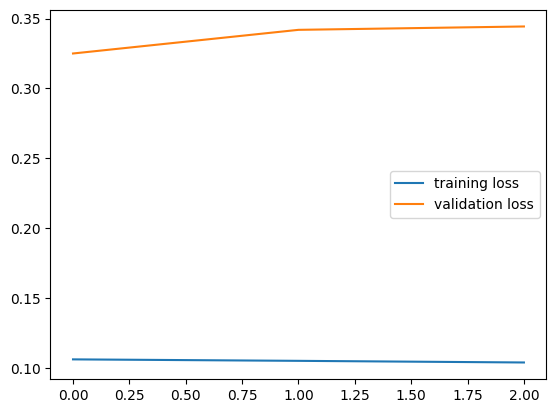

In [ ]:
plt.plot(np.arange(num_epochs),train_losses, label = "training loss")
plt.plot(np.arange(num_epochs),val_losses,label = "validation loss")
plt.legend()
plt.show()

In [ ]:
checkpoint_path = 'LSTM3.pth'
checkpoint = {'model': best_nlp_model.state_dict(),
              'optimizer': optimizer.state_dict(),
              'epoch': num_epochs}
torch.save(checkpoint, checkpoint_path)

In [ ]:
submission = predict_test_data_caption(best_nlp_model, test_loader, device, batch_size)
print(submission.head())
submission.to_csv('predictions.csv', index = False)

C:\Users\david\AppData\Local\Temp\ipykernel_8304\1349538465.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_8304\1349538465.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_8304\1349538465.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_8304\134

     ImageID Labels
0  30000.jpg      1
1  30001.jpg      1
2  30002.jpg      1
3  30003.jpg      1
4  30004.jpg      1


C:\Users\david\AppData\Local\Temp\ipykernel_8304\1349538465.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_8304\1349538465.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


# Define a GRU Model

In [ ]:
class GRUModel(nn.Module):
  def __init__(self, in_feature, hidden_size, n_class):
    super(GRUModel, self).__init__()
    self.in_feature = in_feature
    self.hidden_size = hidden_size
    self.n_class = n_class
    self.fully_connected_1 = nn.Linear(in_feature+self.hidden_size, 2 * self.hidden_size)
    self.fully_connected_2 = nn.Linear(in_feature+self.hidden_size, self.hidden_size)
    self.pred_layer = nn.Linear(self.hidden_size, self.n_class)
    self.tanh = nn.Tanh()
    self.sigmoid = nn.Sigmoid()
  
  def forward(self, input, dtype=torch.float):
    T = input.shape[0]
    batch_size = input.shape[1]
    outputs = torch.zeros(size=(T, batch_size, self.hidden_size), dtype=dtype)
    state = torch.zeros(size=(batch_size, self.hidden_size), dtype=dtype)
    # implement GRU forward procedure here
   
    return outputs, state

  def predict(self, input_state, dtype=torch.float):
    _, last_state = self.forward(input_state)
    predict = self.pred_layer(last_state)
    return predict

# COMBINED MODEL

In order to combine the NLP and classification model we need to concatenate the features and run a third classifier on this concatenated features

Define the third classifier

We need to choose where to put either 19 or 18 labels

In [13]:
n_labels = 18

best_cv_model = Resnext50(num_classes=n_labels)
best_nlp_model = Bi_LSTM_Emb(n_classes=n_labels)
checkpoint = torch.load("ResNet4.pth")
# Load the model state dictionary from the checkpoint
best_cv_model.load_state_dict(checkpoint['model'])

checkpoint = torch.load("BiLSTM3.pth")
# Load the model state dictionary from the checkpoint
best_nlp_model.load_state_dict(checkpoint['model'])
# Define Classifier
classifier = nn.Sequential(
    nn.Linear(in_features=36, out_features=3100),
    nn.ReLU(),
    nn.Linear(in_features=3100, out_features=n_labels),
    nn.Sigmoid()
)


# Switch model to GPU.
best_cv_model = best_cv_model.to(device)
best_nlp_model = best_nlp_model.to(device)
classifier = classifier.to(device)

tokenizer = Tokenizer()
     

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


NameError: name 'Bi_LSTM_Emb' is not defined

In [ ]:
criterion = nn.BCELoss().to(device=device)
optimizer = optim.Adam(classifier.parameters(), lr=lr)

In [ ]:
epochs = 20
train_losses = torch.zeros(num_epochs)
val_losses = torch.zeros(num_epochs)
f1_scores = torch.zeros(num_epochs)
iter = 0
test_frequency = 100 
saving_freq = 1
for epoch in range(epochs):
    batch_loss_values = []
    train_loss=0
    for el in train_loader:
        best_cv_model.train()
        best_nlp_model.train()

        # images part
        targets = el['label'].to(device)
        images = el['image'].to(device)
        # NLP part
        captions = tokenizer.tokenize(el['caption'], seq_len, word_index)
        captions = torch.from_numpy(np.array(captions)).to(device)

        # combining
        optimizer.zero_grad()
        img_out = best_cv_model(images)
        nlp_out = best_nlp_model(captions)
        concatenating_outs = torch.concat((img_out, nlp_out), 1)

        combined_model = classifier(concatenating_outs)
        
        #loss and backward pass
        loss = criterion(combined_model, targets.type(torch.float))
        train_loss += loss.item()
        if i % 100 == 0:
            print(loss.item())
        # bl_value = loss.item()
        # print(bl_value)

        loss.backward()
        

        optimizer.step()
        # optimizer.zero_grad() ### WHY??

    #     # batch_loss_values.append(bl_value)
    #     val_loss = 0
    #     with torch.no_grad():
    #     #     res = calculate_metrics(combined_model.cpu().numpy(), targets.cpu().numpy())
    #     #     print(res['f1_score'])
    #     # if iter % test_frequency == 0:
    #     #     with torch.no_grad():
    #     #         model_res = []
    #     #         targets = []
    #         y_pred = []
    #         y_true = []
    #         for data in valid_loader:
    #             best_cv_model.eval()
    #             best_nlp_model.eval()

    #             # images part
    #             targets = data['label'].to(device)
    #             images = data['image'].to(device)

    #             # NLP part
    #             captions = tokenizer.tokenize(data['caption'], seq_len, word_index)
    #             captions = torch.from_numpy(np.array(captions)).to(device)

    #             # combining
    #             img_out = best_cv_model(images)
    #             nlp_out = best_nlp_model(captions)

    #             combined_outs = classifier(torch.concat((img_out, nlp_out), 1))
    #             loss_combined = criterion(combined_outs,targets)
    #             val_loss += loss_combined.item()
    #             combined_outs = combined_outs.cpu().numpy()
    #             argmax_indices = np.argmax(combined_outs, axis=1)
    #             combined_outs[np.arange(combined_outs.shape[0]), argmax_indices] = 1
    #             predicted = np.round(combined_outs)
    #             y_pred.extend(predicted)
    #             y_true.extend(targets.cpu().numpy())
    #         y_pred = np.array(y_pred)
    #         y_true = np.array(y_true)
    #         res = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
            
    #     #  {'f1_score' : res, 'loss' : val_loss/len(valid_loader)}

    print(f"epoch {epoch}")
    # train_losses[it] = train_loss/len(train_loader)
    # # result = best_nlp_model.calculate_f1_score_and_loss(valid_loader, criterion=criterion, device=device)
    # val_losses[it] = val_loss/len(valid_loader)
    # f1_scores[it] = res
    # print("epoch:{:2d} iter:{:3d} train: loss:{:.3f}".format(epoch, iter, loss_val))


C:\Users\david\AppData\Local\Temp\ipykernel_47812\375505942.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19


In [ ]:
device

device(type='cuda')

In [ ]:
checkpoint_path = 'classifier6.pth'
checkpoint = {'model': classifier.state_dict(),
              'optimizer': optimizer.state_dict(),
              'epoch': num_epochs}
torch.save(checkpoint, checkpoint_path)

In [ ]:
plt.plot(np.arange(num_epochs),train_losses, label = "training loss")
plt.plot(np.arange(num_epochs),val_losses,label = "validation loss")
plt.legend()
plt.show()

In [ ]:
def predict_test_data_combined(model, test_loader, device, batch_size):
    best_cv_model.eval()
    best_nlp_model.eval()
    classifier.eval()
    y_pred = torch.zeros(len(test_data), n_labels)
    df_pred = pd.DataFrame()
    df_pred['ImageID'] = ["" for i in range(len(test_data))]
    df_pred['Labels'] = ["" for i in range(len(test_data))]
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            #captions
            captions = tokenizer.tokenize(data['caption'], seq_len, word_index)
            captions = torch.from_numpy(np.array(captions)).to(device)

            #images
            images = data['image'].to(device)

            #captions = data['Caption'].to(device)
            #optimizer.zero_grad()
            img_out = best_cv_model(images)
            nlp_out = best_nlp_model(captions)
            concatenating_outs = torch.concat((img_out, nlp_out), 1)
            combined_model_pred = classifier(concatenating_outs)
            _, argmax_indices = torch.max(combined_model_pred, dim=1)
            combined_model_pred[torch.arange(combined_model_pred.size(0)), argmax_indices] = 1
            combined_model_pred = (combined_model_pred >= 0.5).type(torch.uint8)
            start = i*batch_size
            end = min((i+1)*batch_size, len(test_data))
            indices = combined_model_pred.nonzero()
            indices[indices[:, 1] > 10, 1] += 1
            # print(indices)
            indices_by_row = torch.split(indices[:, 1], indices[:, 0].unique(return_counts=True)[1].tolist())
            # print(indices_by_row)
            results = [" ".join([str(idx.item()+1) for idx in row]) for row in indices_by_row]
            df_pred["ImageID"][start:end] = data['name']
            df_pred["Labels"][start:end] = results

    return df_pred

In [ ]:
pred = predict_test_data_combined(combined_model, test_loader, device,batch_size=batch_size)

C:\Users\david\AppData\Local\Temp\ipykernel_47812\1349538465.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_47812\1349538465.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_47812\1349538465.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_47812

In [ ]:
pred

,ImageID,Labels
0,30000.jpg,1
1,30001.jpg,1
2,30002.jpg,1
3,30003.jpg,1
4,30004.jpg,1
...,...,...
9995,39995.jpg,1
9996,39996.jpg,3 4 8
9997,39997.jpg,1
9998,39998.jpg,1


In [ ]:
pred.to_csv('predictions.csv',index=False)

In [161]:
n_labels = 18

best_cv_model = Resnext50(num_classes=n_labels)
checkpoint = torch.load("ResNet4.pth",map_location=torch.device('cpu'))
# Load the model state dictionary from the checkpoint
best_cv_model.load_state_dict(checkpoint['model'])



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [162]:
best_cv_model = best_cv_model.to(device)

In [163]:
df_train.head()

,ImageID,Labels,Caption,1,2,3,4,5,6,7,...,9,10,11,13,14,15,16,17,18,19
0,0.jpg,[1],Woman in swim suit holding parasol on sunny day.,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.jpg,"[1, 19]",A couple of men riding horses on top of a gree...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2.jpg,[1],They are brave for riding in the jungle on tho...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.jpg,"[8, 3, 13]",a black and silver clock tower at an intersect...,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,4.jpg,"[8, 3, 7]",A train coming to a stop on the tracks out side.,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [164]:
train_data[0]['label']

/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [165]:
device

device(type='mps')

In [166]:
best_cv_model.calculate_f1_score_and_loss(valid_loader, criterion=criterion, device=device)

/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/3251282898.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


{'f1_score': 0.8163996793330126, 'loss': tensor(0.0997)}

In [114]:
valid_data[0]['name'], valid_data[0]['caption']

/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_21348/375505942.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


('25500.jpg', 'Woman in swim suit holding parasol on sunny day.')